# SET UP

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import imutils
import glob
from skimage import exposure
from skimage import feature
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## I. Lý thuyết tính toán

In [2]:
# Đọc và chuyển ảnh qua Grayscale
image = cv2.imread(r'./Dataset/train/9/01.jpeg', cv2.IMREAD_GRAYSCALE)

In [4]:
def _subImage(image1, string1 ,image2, string2):
    fix, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].imshow(image1, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(string1)
    axs[1].imshow(image2, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(string2)
    plt.show()

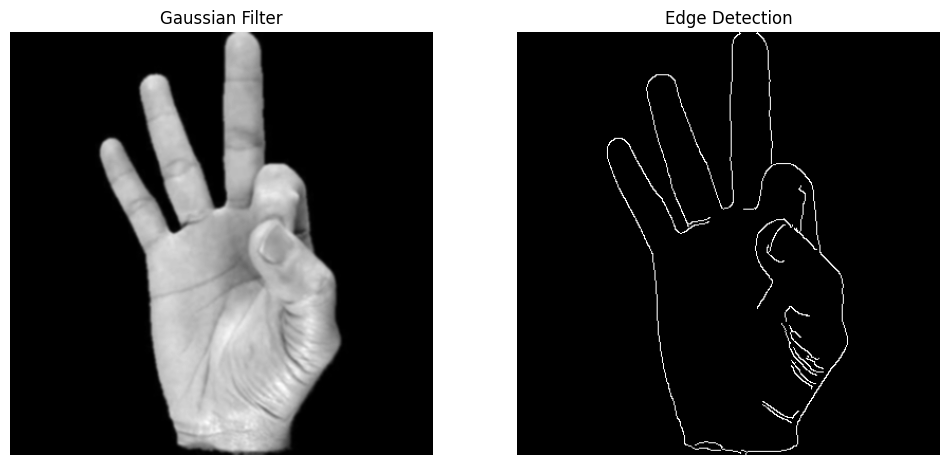

In [5]:
gau_image = cv2.GaussianBlur(image, (5,5), 0) # Giam nhieu
edges = cv2.Canny(gau_image, 50, 150) # Phat hien bien su dung Cannt function

# Hiển thị ảnh sau khi tách biên
_subImage(gau_image, "Gaussian Filter", edges, "Edge Detection")


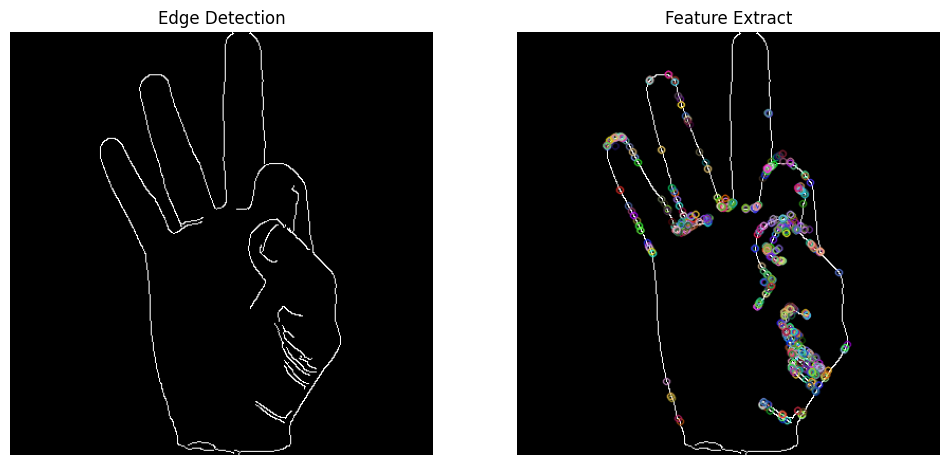

In [50]:
orb = cv2.ORB_create()
key, des = orb.detectAndCompute(edges, None)
image_extract = cv2.drawKeypoints(edges, key, None, flags=0)

_subImage(edges, "Edge Detection", image_extract, "Feature Extract")


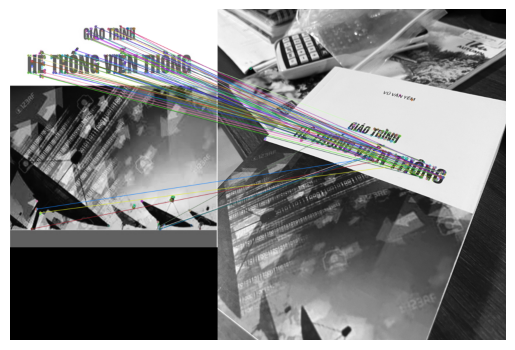

In [58]:
import numpy as np
import cv2


# Read the query image as query_img
# and train image This query image
# is what you need to find in train image
# Save it in the same directory
# with the name image.jpg
query_img = cv2.imread('./img.png')
# query_img = cv2.resize(query_img, (400,400))
train_img = cv2.imread('./img_1.png')
train_img = cv2.resize(train_img, (1000,1000))

# Convert it to grayscale
query_img_bw = cv2.cvtColor(query_img,cv2.COLOR_BGR2GRAY)
train_img_bw = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)

# Initialize the ORB detector algorithm
orb = cv2.ORB_create()

# Now detect the keypoints and compute
# the descriptors for the query image
# and train image
queryKeypoints, queryDescriptors = orb.detectAndCompute(query_img_bw,None)
trainKeypoints, trainDescriptors = orb.detectAndCompute(train_img_bw,None)

# Initialize the Matcher for matching
# the keypoints and then match the
# keypoints
matcher = cv2.BFMatcher()
matches = matcher.match(queryDescriptors,trainDescriptors)

# draw the matches to the final image
# containing both the images the drawMatches()
# function takes both images and keypoints
# and outputs the matched query image with
# its train image
final_img = cv2.drawMatches(query_img_bw, queryKeypoints, train_img_bw, trainKeypoints, matches[:70],None)
final_img = cv2.resize(final_img, (1200,800))

# # Show the final image
# cv2.imshow("Compere", final_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(final_img, cmap='plasma')
plt.axis('off')
plt.show()

# II. Xử lý biên và trích xuất đặc trưng

In [38]:
def _preprocessing(fileType):
    data = []
    labels = []
    orb = cv2.ORB_create()

    for path in glob.glob(fileType):
        _, type, fn = path.split('\\')
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.GaussianBlur(img, (5,5), 0)
        edges = cv2.Canny(img, 50, 150)

        queryKeypoints, descriptors = orb.detectAndCompute(edges, None)
        descriptors = descriptors.flatten() #Chuyen thanh mang 1 chieu
        data.append(descriptors)
        labels.append(type)
    data = np.array(data, dtype=object)
    labels = np.array(labels, dtype=object)
    return data, labels

data, labels= _preprocessing('./Dataset/train/**/*.jpeg')


In [39]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(456,) (114,) (456,) (114,)


In [ ]:
model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='distance')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score1 = accuracy_score(y_test, y_pred)
print(accuracy_score1)

In [23]:
def _save(path, obj):
    with open(path, 'wb') as fn:
        pickle.dump(obj, fn)

## III. Chuyển đổi dữ liệu

In [ ]:
def _transform_data(data, labels):
    # Tạo input array X
    X = np.array(data)
    # Tạo output array y
    le = LabelEncoder()
    le.fit(labels)
    y = le.transform(labels)
    y_ind = np.unique(y)
    y_dict = dict(zip(y_ind, le.classes_))
    return X, y, y_dict, le

X_train, y_train, y_dict, le = _transform_data(data, labels)
X_train
# y_train.shape

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [43]:
n_neighbors_list = list(range(1, 11))
result_L1 = []
result_L2 = []
for n_neighbors in n_neighbors_list:
    # Mô hình KNN với distance measure là L1
    model_L1 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric_params=None, n_jobs=None, n_neighbors=n_neighbors, p=1,
           weights='distance')
    model_L1.fit(X_train, y_train)
    # Dự đoán nhãn lớp trên tập kiểm tra
    y_pred = model_L1.predict(X_test)
    accuracy_L1 = accuracy_score(y_test, y_pred)
    result_L1.append(accuracy_L1)


    # Mô hình KNN với distance measure là L2
    model_L2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric_params=None, n_jobs=None, n_neighbors=n_neighbors, p=2,
           weights='distance')
    model_L2.fit(X_train, y_train)
    # Dự đoán nhãn lớp trên tập kiểm tra
    y_pred = model_L2.predict(X_test)
    accuracy_L2 = accuracy_score(y_test, y_pred)
    result_L2.append(accuracy_L2)

plt.plot(n_neighbors_list, result_L1, marker='o', label='Minkowski')
plt.plot(n_neighbors_list, result_L2, marker='o', label='Euclidean')
plt.xlabel('K_Neighbors')
plt.ylabel('Acurancy')
plt.title('Minkowski and Euclidean')
plt.legend()
plt.show()

del result_L1 # Phải xóa đi không run lại nó lại điền tiếp kết quả zô mảng --> kết quả bị sai nha
del result_L2

D:\2022.2\XLA\HandGestureRecognition\venv\lib\site-packages\sklearn\utils\_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


ValueError: Expected 2D array, got 1D array instead:
array=[array([0.00784314, 0.59607843, 0.74901961, ..., 0.69803922, 0.82352941,
        0.15686275])
 array([0.07843137, 0.68235294, 0.5254902 , ..., 0.50196078, 0.70980392,
        0.97647059])
 array([0.28627451, 0.20784314, 0.09803922, ..., 0.8       , 0.7254902 ,
        0.8627451 ])
 array([0.20784314, 0.07843137, 1.        , ..., 0.74509804, 0.60392157,
        0.54901961])
 array([0.34901961, 0.1254902 , 0.09803922, ..., 0.54117647, 0.94117647,
        0.65882353])
 array([0.47843137, 0.18823529, 0.47843137, ..., 0.49803922, 0.99607843,
        0.58823529])
 array([0.47058824, 0.62745098, 0.61568627, ..., 0.01176471, 0.51372549,
        0.63137255])
 array([0.21568627, 0.80392157, 0.41568627, ..., 0.51764706, 0.16862745,
        0.12941176])
 array([0.47058824, 0.1254902 , 0.6       , ..., 0.97647059, 0.31372549,
        0.12941176])
 array([0.47058824, 0.1254902 , 0.61176471, ..., 0.03137255, 0.70980392,
        0.85882353])
 array([0.50980392, 0.62352941, 0.05490196, ..., 0.98431373, 0.32156863,
        0.1254902 ])
 array([0.4745098 , 0.18823529, 0.61176471, ..., 0.49019608, 0.32156863,
        0.95686275])
 array([0.4745098 , 0.38823529, 0.34509804, ..., 0.65882353, 0.56470588,
        0.15686275])
 array([0.47058824, 0.1254902 , 0.10980392, ..., 0.76470588, 0.80784314,
        0.32156863])
 array([0.42745098, 0.62745098, 0.61568627, ..., 0.60784314, 0.2745098 ,
        0.97647059])
 array([0.37647059, 0.19607843, 0.55686275, ..., 0.94509804, 0.02352941,
        0.38431373])
 array([0.01176471, 0.62745098, 0.38823529, ..., 0.65882353, 0.2627451 ,
        0.44313725])
 array([0.47058824, 0.1254902 , 0.09803922, ..., 0.65882353, 0.43921569,
        0.7254902 ])
 array([0.4745098 , 0.1254902 , 0.11372549, ..., 0.97647059, 0.43921569,
        0.12941176])
 array([0.43921569, 0.18823529, 0.10980392, ..., 0.07058824, 0.64705882,
        0.67058824])
 array([0.30196078, 0.20392157, 0.74117647, ..., 0.56078431, 0.69411765,
        0.52156863])
 array([0.23137255, 0.0745098 , 0.41176471, ..., 0.73333333, 0.43921569,
        0.87843137])
 array([0.47058824, 0.62745098, 0.72156863, ..., 0.95294118, 0.76078431,
        0.63137255])
 array([0.47058824, 0.18823529, 0.98823529, ..., 0.95294118, 0.1372549 ,
        0.50588235])
 array([0.50980392, 0.80392157, 0.38823529, ..., 0.66666667, 0.43921569,
        0.72156863])
 array([0.47058824, 0.1254902 , 0.09411765, ..., 0.67058824, 0.31372549,
        0.95686275])
 array([0.20392157, 0.13333333, 0.5254902 , ..., 0.        , 0.63137255,
        0.6627451 ])
 array([0.38039216, 0.63529412, 0.86666667, ..., 0.72156863, 0.43921569,
        0.15686275])
 array([0.35294118, 0.19607843, 0.96470588, ..., 0.65882353, 0.20392157,
        0.22352941])
 array([0.09803922, 0.55294118, 0.29411765, ..., 0.72941176, 0.12941176,
        0.22352941])
 array([0.58431373, 0.64705882, 0.5254902 , ..., 0.18823529, 0.2627451 ,
        0.65882353])
 array([0.28627451, 0.1254902 , 0.23921569, ..., 0.49019608, 0.81568627,
        0.96470588])
 array([0.48627451, 0.69019608, 0.97254902, ..., 0.98431373, 0.98039216,
        0.58039216])
 array([0.42745098, 0.1254902 , 0.6       , ..., 0.44313725, 0.51372549,
        0.47843137])
 array([0.42745098, 0.69803922, 0.69411765, ..., 0.04705882, 0.99215686,
        0.80784314])
 array([0.38431373, 0.1254902 , 0.81568627, ..., 0.65882353, 0.4       ,
        0.43921569])
 array([0.04313725, 0.1254902 , 0.96862745, ..., 0.12156863, 0.20784314,
        0.85098039])
 array([0.00784314, 0.54117647, 0.5254902 , ..., 0.53333333, 0.14509804,
        0.69019608])
 array([0.4745098 , 0.1254902 , 0.09803922, ..., 0.7254902 , 0.12941176,
        0.16078431])
 array([0.47843137, 0.18823529, 0.97254902, ..., 0.95294118, 0.76078431,
        0.63137255])
 array([0.23137255, 0.05098039, 0.41568627, ..., 0.73333333, 0.32156863,
        0.87843137])
 array([0.47058824, 0.1254902 , 0.98823529, ..., 0.41960784, 0.34117647,
        0.84313725])
 array([0.32156863, 0.6745098 , 0.24313725, ..., 0.25098039, 0.51372549,
        0.00784314])
 array([0.47058824, 0.1254902 , 0.09803922, ..., 0.88235294, 0.77647059,
        0.44313725])
 array([0.32941176, 0.69019608, 0.61176471, ..., 0.94509804, 0.78039216,
        0.63921569])
 array([0.19215686, 0.14117647, 0.90588235, ..., 0.03137255, 0.55294118,
        0.10588235])
 array([0.41176471, 0.19607843, 0.09803922, ..., 0.69019608, 0.1254902 ,
        0.0627451 ])
 array([0.09803922, 0.80392157, 0.48235294, ..., 0.04313725, 0.69411765,
        0.51764706])
 array([0.47058824, 0.1254902 , 0.10980392, ..., 0.15686275, 0.37647059,
        0.63529412])
 array([0.48627451, 0.62745098, 0.61176471, ..., 0.94509804, 0.12941176,
        0.19215686])
 array([0.47058824, 0.18823529, 0.23529412, ..., 0.98431373, 0.83137255,
        0.13333333])
 array([0.49019608, 0.69019608, 0.74117647, ..., 0.62745098, 0.16078431,
        0.61568627])
 array([0.4745098 , 0.18823529, 0.7254902 , ..., 0.39215686, 0.67843137,
        0.80784314])
 array([0.49411765, 0.62745098, 0.70588235, ..., 0.62745098, 0.44313725,
        0.62745098])
 array([0.30196078, 0.1254902 , 0.61568627, ..., 0.70196078, 0.14901961,
        0.47058824])
 array([0.47058824, 0.18823529, 0.61568627, ..., 0.10980392, 0.49803922,
        0.80784314])
 array([0.42745098, 0.18823529, 0.74117647, ..., 0.29803922, 0.55294118,
        0.52941176])
 array([0.39607843, 0.1254902 , 0.6       , ..., 0.49803922, 0.80784314,
        0.00784314])
 array([0.77647059, 0.6745098 , 0.58823529, ..., 0.66666667, 0.69411765,
        0.84705882])
 array([0.41568627, 0.63529412, 0.9254902 , ..., 0.43921569, 0.20392157,
        0.14901961])
 array([0.47058824, 0.18823529, 0.59607843, ..., 0.7254902 , 0.43921569,
        0.16078431])
 array([0.18823529, 0.81176471, 0.41568627, ..., 0.04313725, 0.95686275,
        0.88627451])
 array([0.47058824, 0.18823529, 0.22352941, ..., 0.73333333, 0.43921569,
        0.97647059])
 array([0.00392157, 0.21176471, 0.9372549 , ..., 0.54117647, 0.75294118,
        0.6627451 ])
 array([0.4745098 , 0.18823529, 0.10980392, ..., 0.53333333, 0.4745098 ,
        0.92156863])
 array([0.47058824, 0.1254902 , 0.7372549 , ..., 0.88627451, 0.47058824,
        0.1254902 ])
 array([0.48627451, 0.1254902 , 0.61176471, ..., 0.03921569, 0.98039216,
        0.54901961])
 array([0.38039216, 0.62745098, 0.61568627, ..., 0.49019608, 0.80784314,
        0.44705882])
 array([0.48627451, 0.1254902 , 0.59607843, ..., 0.94117647, 0.12941176,
        0.19215686])
 array([0.4745098 , 0.89019608, 0.34509804, ..., 0.44313725, 0.64705882,
        0.67058824])
 array([0.20784314, 0.55294118, 0.41960784, ..., 0.43921569, 0.17647059,
        0.41568627])
 array([0.00784314, 0.52156863, 0.09803922, ..., 0.60392157, 0.45490196,
        0.47058824])
 array([0.10196078, 0.86666667, 0.38431373, ..., 0.98431373, 0.43921569,
        0.87843137])
 array([0.4745098 , 0.1254902 , 0.61568627, ..., 0.70980392, 0.18039216,
        0.99215686])
 array([0.10196078, 0.36470588, 0.44705882, ..., 0.7254902 , 0.43921569,
        0.65882353])
 array([0.27058824, 0.1254902 , 0.61568627, ..., 0.56078431, 0.36078431,
        0.95294118])
 array([0.41176471, 0.18823529, 0.22352941, ..., 0.45882353, 0.56078431,
        0.34117647])
 array([0.00784314, 0.55294118, 0.02352941, ..., 0.23137255, 0.41568627,
        0.50196078])
 array([0.47058824, 0.1254902 , 0.59607843, ..., 0.15686275, 0.45882353,
        0.87843137])
 array([0.49411765, 0.13333333, 0.96470588, ..., 0.51764706, 0.19215686,
        0.4745098 ])
 array([0.12941176, 0.65098039, 0.5254902 , ..., 0.15686275, 0.39215686,
        0.00784314])
 array([0.47058824, 0.1254902 , 0.61568627, ..., 0.72941176, 0.14117647,
        0.22352941])
 array([0.47058824, 0.1254902 , 0.10980392, ..., 0.03921569, 0.70588235,
        0.72941176])
 array([0.47843137, 0.1254902 , 0.21176471, ..., 0.90980392, 0.47058824,
        0.50196078])
 array([0.26666667, 0.62745098, 0.55686275, ..., 0.67058824, 0.31372549,
        0.95686275])
 array([0.23137255, 0.07058824, 0.38823529, ..., 0.03137255, 0.80784314,
        0.03921569])
 array([0.47058824, 0.1254902 , 0.09803922, ..., 0.37254902, 0.67843137,
        0.8745098 ])
 array([0.2745098 , 0.93333333, 0.51764706, ..., 0.98039216, 0.31372549,
        0.4745098 ])
 array([0.41176471, 0.19607843, 0.4745098 , ..., 0.95294118, 0.90196078,
        0.62745098])
 array([0.03921569, 0.61568627, 0.4       , ..., 0.24705882, 0.4745098 ,
        0.54901961])
 array([0.47058824, 0.18823529, 0.12156863, ..., 0.44313725, 0.52941176,
        0.44705882])
 array([0.47058824, 0.19607843, 0.98823529, ..., 0.05490196, 0.70980392,
        0.29411765])
 array([0.47058824, 0.1254902 , 0.61568627, ..., 0.48627451, 0.54509804,
        0.55686275])
 array([0.48627451, 0.62745098, 0.7372549 , ..., 0.42745098, 0.29019608,
        0.58039216])
 array([0.22352941, 0.07843137, 0.77254902, ..., 0.62745098, 0.12941176,
        0.4745098 ])
 array([0.2       , 0.8745098 , 0.41960784, ..., 0.31372549, 0.67843137,
        0.29019608])
 array([0.01568627, 0.62745098, 0.52941176, ..., 0.46666667, 0.23921569,
        0.4627451 ])
 array([0.47058824, 0.1254902 , 0.09803922, ..., 0.94509804, 0.52156863,
        0.62745098])
 array([0.35294118, 0.13333333, 0.3372549 , ..., 0.07058824, 0.64705882,
        0.92156863])
 array([0.47058824, 0.18823529, 0.49411765, ..., 0.49803922, 0.73333333,
        0.52941176])
 array([0.29411765, 0.19607843, 0.96862745, ..., 0.55294118, 0.48627451,
        0.82745098])
 array([0.03921569, 0.69019608, 0.19607843, ..., 0.95294118, 0.26666667,
        0.44705882])
 array([0.38431373, 0.65882353, 0.71764706, ..., 0.04705882, 0.87058824,
        0.29019608])
 array([0.4745098 , 0.1254902 , 0.11372549, ..., 0.02352941, 0.18431373,
        0.62352941])
 array([0.34901961, 0.18823529, 0.61568627, ..., 0.56078431, 0.67843137,
        0.82745098])
 array([0.45490196, 0.62745098, 0.61176471, ..., 0.05490196, 0.23529412,
        0.53333333])
 array([0.41176471, 0.19607843, 0.21960784, ..., 0.94901961, 0.25882353,
        0.19215686])
 array([0.28627451, 0.19607843, 0.61568627, ..., 0.54117647, 0.44313725,
        0.65882353])
 array([0.47058824, 0.1254902 , 0.11372549, ..., 0.72941176, 0.20392157,
        0.22352941])
 array([0.20784314, 0.25490196, 0.43529412, ..., 0.44313725, 0.77647059,
        0.13333333])
 array([0.41960784, 0.18823529, 0.91372549, ..., 0.03137255, 0.80784314,
        0.03921569])
 array([0.39607843, 0.14901961, 0.86666667, ..., 0.54901961, 0.46666667,
        0.96078431])
 array([0.47058824, 0.62745098, 0.61568627, ..., 0.62745098, 0.14509804,
        0.34901961])
 array([0.00784314, 0.72156863, 0.74901961, ..., 0.98431373, 0.82352941,
        0.12941176])
 array([0.34509804, 0.1254902 , 0.09803922, ..., 0.96862745, 0.54509804,
        0.0627451 ])
 array([0.32941176, 0.62745098, 0.61568627, ..., 0.55686275, 0.4627451 ,
        0.99215686])
 array([0.47843137, 0.18823529, 0.99607843, ..., 0.72941176, 0.45490196,
        0.1254902 ])
 array([0.17647059, 0.70588235, 0.89803922, ..., 0.53333333, 0.2627451 ,
        0.64705882])
 array([0.47058824, 0.62745098, 0.61568627, ..., 0.47058824, 0.56862745,
        0.61568627])
 array([0.44313725, 0.18823529, 0.61568627, ..., 0.60392157, 0.94117647,
        0.65882353])
 array([0.23921569, 0.30980392, 0.40392157, ..., 1.        , 0.95686275,
        0.38039216])
 array([0.48627451, 0.1254902 , 0.6       , ..., 0.43921569, 0.64705882,
        0.48235294])
 array([0.47058824, 0.18823529, 0.47843137, ..., 0.98431373, 0.43921569,
        0.1254902 ])
 array([0.24313725, 0.55294118, 0.2       , ..., 0.47843137, 0.59215686,
        0.91764706])
 array([0.28627451, 0.69019608, 0.6       , ..., 0.        , 0.64705882,
        0.98431373])
 array([0.48627451, 0.18823529, 0.61568627, ..., 0.55686275, 0.7254902 ,
        0.05098039])
 array([0.03921569, 0.8745098 , 0.43529412, ..., 0.98431373, 0.64313725,
        0.44705882])
 array([0.23137255, 0.0745098 , 0.41176471, ..., 0.04705882, 0.05882353,
        0.54117647])
 array([0.34509804, 0.18823529, 0.49019608, ..., 0.72941176, 0.37647059,
        0.21960784])
 array([0.28627451, 0.18823529, 0.22352941, ..., 0.72941176, 0.44313725,
        0.22352941])
 array([0.4745098 , 0.1254902 , 0.23921569, ..., 0.53333333, 0.25882353,
        0.64705882])
 array([0.42745098, 0.62745098, 0.09411765, ..., 0.44313725, 0.70588235,
        0.25882353])
 array([0.11764706, 0.30980392, 0.38431373, ..., 0.98431373, 0.43921569,
        0.18823529])
 array([0.41176471, 0.1254902 , 0.10980392, ..., 0.50196078, 0.15686275,
        0.64705882])
 array([0.39607843, 0.65098039, 0.80392157, ..., 0.70196078, 0.63529412,
        0.65882353])
 array([0.35294118, 0.69019608, 0.7372549 , ..., 0.73333333, 0.39215686,
        0.2627451 ])
 array([0.47058824, 0.18823529, 0.49411765, ..., 0.95294118, 0.65098039,
        0.62745098])
 array([0.4745098 , 0.1254902 , 0.09803922, ..., 0.67058824, 0.30588235,
        0.60784314])
 array([0.54509804, 0.43921569, 0.74901961, ..., 0.95294118, 0.80784314,
        0.00784314])
 array([0.25490196, 0.13333333, 0.86666667, ..., 0.65882353, 0.45098039,
        0.88235294])
 array([0.27058824, 0.14901961, 0.80392157, ..., 1.        , 0.43921569,
        0.96078431])
 array([0.42352941, 0.1254902 , 0.74117647, ..., 0.31764706, 0.52941176,
        0.45098039])
 array([0.47058824, 0.1254902 , 0.21960784, ..., 0.30196078, 0.85490196,
        0.95686275])
 array([0.0745098 , 0.74509804, 0.11764706, ..., 0.87843137, 0.2627451 ,
        0.19215686])
 array([0.20784314, 0.70588235, 0.90588235, ..., 0.65882353, 0.43921569,
        0.7254902 ])
 array([0.47058824, 0.18823529, 0.49411765, ..., 0.94117647, 0.52941176,
        0.19215686])
 array([0.52941176, 0.61568627, 0.71372549, ..., 0.68235294, 0.97254902,
        0.76862745])
 array([0.16862745, 0.0745098 , 0.40784314, ..., 0.25098039, 0.52941176,
        0.41568627])
 array([0.48235294, 0.14901961, 0.47058824, ..., 0.73333333, 0.43921569,
        0.94117647])
 array([0.41176471, 0.19607843, 0.74117647, ..., 0.04705882, 0.6745098 ,
        0.72941176])
 array([0.01176471, 0.59607843, 0.0745098 , ..., 0.95294118, 0.00392157,
        0.19215686])
 array([0.20784314, 0.70588235, 0.99215686, ..., 0.94901961, 0.25098039,
        0.12941176])
 array([0.31764706, 0.13333333, 0.35686275, ..., 0.99607843, 0.36862745,
        0.96078431])
 array([0.28627451, 0.19607843, 0.22352941, ..., 0.96470588, 0.67843137,
        0.49019608])
 array([0.25490196, 0.18823529, 0.11372549, ..., 0.21176471, 1.        ,
        0.8745098 ])
 array([0.47058824, 0.1254902 , 0.61176471, ..., 0.45490196, 0.5372549 ,
        0.02745098])
 array([0.35294118, 0.18823529, 0.71372549, ..., 1.        , 0.98039216,
        0.58039216])
 array([0.25490196, 0.19607843, 0.11372549, ..., 0.50980392, 0.92156863,
        0.62745098])
 array([0.47058824, 0.18823529, 0.23529412, ..., 0.94509804, 0.38039216,
        0.69411765])
 array([0.00392157, 0.13333333, 0.27843137, ..., 0.82352941, 0.63137255,
        0.65882353])
 array([0.47058824, 0.1254902 , 0.23921569, ..., 0.98431373, 0.86666667,
        0.38431373])
 array([0.34901961, 0.18823529, 0.61568627, ..., 0.46666667, 0.67058824,
        0.5254902 ])
 array([0.28627451, 0.13333333, 0.11372549, ..., 0.03137255, 0.70588235,
        0.53333333])
 array([0.00784314, 0.56078431, 0.00784314, ..., 0.15686275, 0.40392157,
        0.64313725])
 array([0.25490196, 0.18823529, 0.11372549, ..., 0.98431373, 0.28235294,
        0.1254902 ])
 array([0.20784314, 0.64313725, 0.96862745, ..., 0.30588235, 0.7254902 ,
        0.83529412])
 array([0.03529412, 0.19607843, 0.96862745, ..., 0.25882353, 0.64705882,
        0.85490196])
 array([0.28627451, 0.14117647, 0.55294118, ..., 0.70196078, 0.4       ,
        0.1254902 ])
 array([0.00392157, 0.01568627, 0.30980392, ..., 0.75294118, 0.14509804,
        0.22352941])
 array([0.0745098 , 0.56078431, 0.48235294, ..., 0.72941176, 0.39215686,
        0.21960784])
 array([0.34901961, 0.63529412, 0.58431373, ..., 0.95294118, 0.82745098,
        0.43921569])
 array([0.35686275, 0.18823529, 0.46666667, ..., 0.39607843, 0.55294118,
        0.02745098])
 array([0.36470588, 0.1254902 , 0.61568627, ..., 0.4745098 , 0.60392157,
        0.50980392])
 array([0.49411765, 0.72156863, 0.21176471, ..., 0.98431373, 0.43921569,
        0.62745098])
 array([0.47058824, 0.69019608, 0.11372549, ..., 0.15686275, 0.32156863,
        0.47843137])
 array([0.47843137, 0.19607843, 0.45490196, ..., 0.96862745, 0.50588235,
        0.19215686])
 array([0.55686275, 0.43921569, 0.74901961, ..., 0.95294118, 0.56078431,
        0.14509804])
 array([0.2       , 0.86666667, 0.38823529, ..., 1.        , 0.98039216,
        0.58039216])
 array([0.47058824, 0.1254902 , 0.61176471, ..., 0.28235294, 0.64705882,
        0.47843137])
 array([0.31372549, 0.18823529, 0.74117647, ..., 0.7254902 , 0.44705882,
        0.63137255])
 array([0.47058824, 0.1254902 , 0.61176471, ..., 0.03137255, 0.4745098 ,
        0.60784314])
 array([0.19215686, 0.64313725, 0.9372549 , ..., 0.45882353, 0.50588235,
        0.45098039])
 array([0.04313725, 0.69803922, 0.40392157, ..., 0.05882353, 0.22352941,
        0.85098039])
 array([0.34509804, 0.13333333, 0.48627451, ..., 0.05098039, 0.24705882,
        0.87058824])
 array([0.45490196, 0.1254902 , 0.61568627, ..., 0.95294118, 0.77647059,
        0.2       ])
 array([0.37254902, 0.19607843, 1.        , ..., 0.29803922, 0.56078431,
        0.05490196])
 array([0.19215686, 0.55294118, 0.41568627, ..., 0.04705882, 0.05490196,
        0.21176471])
 array([0.27058824, 0.69019608, 0.61568627, ..., 0.03137255, 0.20784314,
        0.98431373])
 array([0.34509804, 0.13333333, 0.36078431, ..., 0.50196078, 0.41176471,
        0.6745098 ])
 array([0.4745098 , 0.13333333, 0.23921569, ..., 0.47843137, 0.44705882,
        0.6       ])
 array([0.16862745, 0.80392157, 0.38823529, ..., 0.60392157, 0.43921569,
        0.65882353])
 array([0.41176471, 0.1254902 , 0.7254902 , ..., 0.89803922, 0.18431373,
        0.3254902 ])
 array([0.48627451, 0.1254902 , 0.59607843, ..., 0.94509804, 0.12941176,
        0.16078431])
 array([0.47058824, 0.1254902 , 0.09411765, ..., 0.45098039, 0.52941176,
        0.01176471])
 array([0.47058824, 0.62745098, 0.6       , ..., 0.94901961, 0.63529412,
        0.19215686])
 array([0.09803922, 0.55294118, 0.41568627, ..., 0.69803922, 0.43921569,
        0.18823529])
 array([0.20784314, 0.8745098 , 0.41960784, ..., 0.25490196, 0.64705882,
        0.45098039])
 array([0.20784314, 0.39607843, 0.92156863, ..., 0.95294118, 0.88627451,
        0.63137255])
 array([0.47058824, 0.1254902 , 0.23921569, ..., 0.13333333, 0.15294118,
        0.3254902 ])
 array([0.49803922, 0.21176471, 1.        , ..., 0.29803922, 0.56078431,
        0.05490196])
 array([0.06666667, 0.62352941, 0.41960784, ..., 0.04705882, 0.48627451,
        0.83921569])
 array([0.40784314, 0.62745098, 0.6       , ..., 0.60392157, 0.63137255,
        0.7254902 ])
 array([0.19215686, 0.81176471, 0.41960784, ..., 0.42745098, 0.23921569,
        0.55686275])
 array([0.48627451, 0.62745098, 0.59607843, ..., 0.60392157, 0.97254902,
        0.53333333])
 array([0.5254902 , 0.68627451, 0.5254902 , ..., 0.45098039, 0.64705882,
        0.13333333])
 array([0.48627451, 0.62745098, 0.09803922, ..., 0.60784314, 0.43921569,
        0.85098039])
 array([0.02352941, 0.6745098 , 0.5254902 , ..., 0.45098039, 0.64705882,
        0.38431373])
 array([0.47058824, 0.1254902 , 0.59607843, ..., 0.28235294, 0.83921569,
        0.47843137])
 array([0.47058824, 0.1254902 , 0.09411765, ..., 0.50196078, 0.25490196,
        0.63137255])
 array([0.29019608, 0.18823529, 0.96470588, ..., 0.94117647, 0.01960784,
        0.4       ])
 array([0.47058824, 0.18823529, 0.49019608, ..., 0.94509804, 0.20784314,
        0.44313725])
 array([0.40784314, 0.64705882, 0.97254902, ..., 0.25098039, 0.67843137,
        0.35686275])
 array([0.09019608, 0.65098039, 0.5254902 , ..., 0.30588235, 0.65490196,
        0.95294118])
 array([0.34901961, 0.18823529, 0.74117647, ..., 0.47058824, 0.95686275,
        0.13333333])
 array([0.64705882, 0.80392157, 0.5254902 , ..., 0.44313725, 0.64705882,
        0.38431373])
 array([0.19215686, 0.21176471, 0.9372549 , ..., 0.32941176, 0.6627451 ,
        0.55686275])
 array([0.00392157, 0.1254902 , 0.84313725, ..., 0.43921569, 0.65098039,
        0.41568627])
 array([0.14509804, 0.66666667, 0.5254902 , ..., 0.25098039, 0.64705882,
        0.66666667])
 array([0.30196078, 0.13333333, 0.61568627, ..., 0.95294118, 0.12941176,
        0.19215686])
 array([0.47058824, 0.1254902 , 0.59607843, ..., 1.        , 0.35294118,
        0.33333333])
 array([0.42745098, 0.64705882, 0.61568627, ..., 0.99607843, 0.15686275,
        0.45098039])
 array([0.64313725, 0.9254902 , 0.5254902 , ..., 0.64313725, 0.2745098 ,
        0.44313725])
 array([0.37647059, 0.63529412, 0.86666667, ..., 0.03137255, 0.69411765,
        0.50196078])
 array([0.20784314, 0.64313725, 0.84313725, ..., 0.94509804, 0.52941176,
        0.19215686])
 array([0.47058824, 0.18823529, 0.09803922, ..., 0.98823529, 0.40784314,
        0.3372549 ])
 array([0.7254902 , 0.0627451 , 0.4745098 , ..., 0.98431373, 0.94117647,
        0.37647059])
 array([0.2       , 0.80392157, 0.38823529, ..., 0.98431373, 0.94117647,
        0.1254902 ])
 array([0.47058824, 0.18823529, 0.7372549 , ..., 0.42745098, 0.29019608,
        0.58039216])
 array([0.33333333, 0.55686275, 0.77647059, ..., 0.98431373, 0.32156863,
        0.37647059])
 array([0.12941176, 0.68235294, 0.5254902 , ..., 0.35686275, 0.5254902 ,
        0.2       ])
 array([0.47058824, 0.62745098, 0.59607843, ..., 0.7254902 , 0.44313725,
        0.16078431])
 array([0.1372549 , 0.68627451, 0.41568627, ..., 0.47058824, 0.14117647,
        0.13333333])
 array([0.83529412, 0.14901961, 0.5254902 , ..., 0.68627451, 0.22352941,
        0.33333333])
 array([0.20784314, 0.25490196, 0.41960784, ..., 0.44313725, 0.77647059,
        0.38431373])
 array([0.48627451, 0.62745098, 0.86666667, ..., 0.50196078, 0.02745098,
        0.45098039])
 array([0.47058824, 0.1254902 , 0.36470588, ..., 0.74901961, 0.47058824,
        0.54901961])
 array([0.09803922, 0.07058824, 0.27843137, ..., 0.52941176, 0.16078431,
        0.45098039])
 array([0.21960784, 0.88235294, 0.47843137, ..., 0.34509804, 0.94117647,
        0.98039216])
 array([0.47058824, 0.1254902 , 0.09803922, ..., 0.92941176, 0.81568627,
        0.96470588])
 array([0.47058824, 0.63529412, 0.31372549, ..., 0.91764706, 0.47058824,
        0.70588235])
 array([0.41176471, 0.13333333, 0.23921569, ..., 0.45098039, 0.64705882,
        0.45098039])
 array([0.38039216, 0.18823529, 0.09803922, ..., 0.39607843, 0.56078431,
        0.32156863])
 array([0.47058824, 0.69019608, 0.61568627, ..., 0.44313725, 0.52156863,
        0.45098039])
 array([0.47058824, 0.18823529, 0.09803922, ..., 0.95294118, 0.2745098 ,
        0.38431373])
 array([0.16862745, 0.19607843, 0.4627451 , ..., 0.45490196, 0.01960784,
        0.25882353])
 array([0.34901961, 0.18823529, 0.23921569, ..., 0.73333333, 0.12941176,
        0.22352941])
 array([0.47058824, 0.1254902 , 0.22352941, ..., 0.03137255, 0.86666667,
        0.54117647])
 array([0.4745098 , 0.18823529, 0.23921569, ..., 0.72156863, 0.44313725,
        0.16078431])
 array([0.03921569, 0.64705882, 0.22745098, ..., 0.98431373, 0.43921569,
        0.40784314])
 array([0.47058824, 0.1254902 , 0.36078431, ..., 0.66666667, 0.32156863,
        0.20784314])
 array([0.12941176, 0.1254902 , 0.30588235, ..., 1.        , 0.32156863,
        0.45490196])
 array([0.12941176, 0.20392157, 0.96862745, ..., 0.75294118, 0.02745098,
        0.48235294])
 array([0.47058824, 0.62745098, 0.59607843, ..., 0.49803922, 0.70980392,
        0.82352941])
 array([0.        , 0.1254902 , 0.3372549 , ..., 0.54117647, 0.43921569,
        0.7372549 ])
 array([0.36470588, 0.69019608, 0.74117647, ..., 0.57254902, 0.62745098,
        0.22352941])
 array([0.03529412, 0.19607843, 0.46666667, ..., 0.30980392, 0.70980392,
        0.83529412])
 array([0.4745098 , 0.1254902 , 0.61568627, ..., 0.29803922, 0.94509804,
        0.6745098 ])
 array([0.47058824, 0.1254902 , 0.09803922, ..., 0.15686275, 0.45882353,
        0.64313725])
 array([0.47058824, 0.62745098, 0.61176471, ..., 0.72941176, 0.43921569,
        0.21960784])
 array([0.19607843, 0.1254902 , 0.3372549 , ..., 0.49019608, 0.64705882,
        0.49803922])
 array([0.6627451 , 0.20392157, 0.42745098, ..., 0.98039216, 0.32156863,
        0.19215686])
 array([0.43921569, 0.1254902 , 0.3372549 , ..., 0.72156863, 0.12941176,
        0.22352941])
 array([0.57647059, 0.05882353, 0.76078431, ..., 0.87843137, 0.52941176,
        0.35686275])
 array([0.09803922, 0.61568627, 0.48235294, ..., 0.42352941, 0.22352941,
        0.55686275])
 array([0.48627451, 0.1254902 , 0.7372549 , ..., 0.98431373, 0.32156863,
        0.63137255])
 array([0.48627451, 0.69019608, 0.7372549 , ..., 0.54117647, 0.7254902 ,
        0.53333333])
 array([0.48627451, 0.18823529, 0.74117647, ..., 0.98431373, 0.79215686,
        0.50980392])
 array([0.30196078, 0.63921569, 0.21960784, ..., 0.49803922, 0.24705882,
        0.84313725])
 array([0.22352941, 0.90588235, 0.40784314, ..., 0.43921569, 0.15294118,
        0.13333333])
 array([0.4745098 , 0.13333333, 0.61568627, ..., 0.74901961, 0.47843137,
        0.58039216])
 array([0.24705882, 0.36470588, 0.38823529, ..., 0.98431373, 0.94117647,
        0.40784314])
 array([0.19215686, 0.6745098 , 0.80392157, ..., 0.32941176, 0.54509804,
        0.10588235])
 array([0.70980392, 0.25490196, 0.41960784, ..., 0.43921569, 0.27843137,
        0.88627451])
 array([0.48627451, 0.69019608, 0.59607843, ..., 0.30196078, 0.6627451 ,
        0.95686275])
 array([0.32941176, 0.6745098 , 0.52941176, ..., 0.68627451, 0.83921569,
        0.45098039])
 array([0.23921569, 0.30196078, 0.40392157, ..., 0.47843137, 0.94117647,
        0.15686275])
 array([0.47058824, 0.13333333, 0.40784314, ..., 0.46666667, 0.64705882,
        0.94901961])
 array([0.47058824, 0.62745098, 0.61568627, ..., 0.26666667, 0.67843137,
        0.62352941])
 array([0.43921569, 0.18823529, 0.11372549, ..., 0.69803922, 0.43921569,
        0.21960784])
 array([0.47058824, 0.62745098, 0.09803922, ..., 0.01568627, 0.17647059,
        0.56078431])
 array([0.4745098 , 0.1254902 , 0.61568627, ..., 0.27058824, 0.55294118,
        0.2627451 ])
 array([0.2745098 , 0.62745098, 0.74901961, ..., 0.45882353, 0.67843137,
        0.5372549 ])
 array([0.2745098 , 0.68235294, 0.5254902 , ..., 0.98431373, 0.31372549,
        0.4745098 ])
 array([0.47058824, 0.18823529, 0.61568627, ..., 0.32941176, 0.56078431,
        0.80784314])
 array([0.0745098 , 0.54117647, 0.25882353, ..., 0.98431373, 0.96470588,
        0.83137255])
 array([0.47058824, 0.18823529, 0.74117647, ..., 0.45490196, 0.55294118,
        0.12156863])
 array([0.04313725, 0.19607843, 0.4627451 , ..., 0.94509804, 0.01568627,
        0.45098039])
 array([0.25882353, 0.72156863, 0.61960784, ..., 0.21960784, 0.94901961,
        0.88627451])
 array([0.25490196, 0.63529412, 0.34117647, ..., 0.73333333, 0.25882353,
        0.15686275])
 array([0.51764706, 0.68235294, 0.56078431, ..., 0.46666667, 0.55686275,
        0.44705882])
 array([0.01176471, 0.62352941, 0.03921569, ..., 0.03137255, 0.4627451 ,
        0.98039216])
 array([0.47058824, 0.18823529, 0.48627451, ..., 0.95294118, 0.01568627,
        0.44313725])
 array([0.01176471, 0.52156863, 0.27843137, ..., 0.90980392, 0.3372549 ,
        0.43921569])
 array([0.34509804, 0.18823529, 0.49411765, ..., 0.33333333, 0.64705882,
        0.98431373])
 array([0.47843137, 0.1254902 , 0.87058824, ..., 0.95294118, 0.38823529,
        0.6745098 ])
 array([0.07843137, 0.01568627, 0.96862745, ..., 0.9254902 , 0.47843137,
        0.89411765])
 array([0.32156863, 0.1254902 , 0.71764706, ..., 0.69411765, 0.01568627,
        0.45098039])
 array([0.10196078, 0.56078431, 0.41568627, ..., 0.97254902, 0.41960784,
        0.50196078])
 array([0.48627451, 0.63137255, 0.7254902 , ..., 0.99607843, 0.83921569,
        0.44313725])
 array([0.01176471, 0.1254902 , 0.90588235, ..., 0.76862745, 0.7254902 ,
        0.86666667])
 array([0.34509804, 0.1254902 , 0.23921569, ..., 0.31764706, 0.78039216,
        0.45098039])
 array([0.49019608, 0.62745098, 0.6       , ..., 0.72156863, 0.31372549,
        0.15686275])
 array([0.2745098 , 0.6745098 , 0.61960784, ..., 0.33333333, 0.54509804,
        0.55686275])
 array([0.16078431, 0.07843137, 0.41176471, ..., 0.61176471, 0.99215686,
        0.4745098 ])
 array([0.47058824, 0.18823529, 0.7372549 , ..., 0.03137255, 0.45882353,
        0.48235294])
 array([0.10588235, 0.24313725, 0.91764706, ..., 0.29803922, 0.08235294,
        0.48235294])
 array([0.40784314, 0.19607843, 0.74117647, ..., 0.70196078, 0.19215686,
        0.1254902 ])
 array([0.51764706, 0.65098039, 0.56078431, ..., 0.46666667, 0.55686275,
        0.44705882])
 array([0.23921569, 0.58039216, 0.9372549 , ..., 0.39215686, 0.17647059,
        0.35686275])
 array([0.43137255, 0.46666667, 0.70588235, ..., 0.16470588, 0.96470588,
        0.68235294])
 array([0.48627451, 0.69019608, 0.7254902 , ..., 0.73333333, 0.43921569,
        0.97254902])
 array([0.09411765, 0.55294118, 0.10196078, ..., 0.58431373, 0.23921569,
        0.44705882])
 array([0.41176471, 0.62745098, 0.6       , ..., 0.94509804, 0.52941176,
        0.2       ])
 array([0.60392157, 0.61568627, 0.4       , ..., 0.11372549, 0.4745098 ,
        0.54901961])
 array([0.47058824, 0.1254902 , 0.11372549, ..., 0.02352941, 0.18431373,
        0.56078431])
 array([0.47843137, 0.18823529, 0.44705882, ..., 0.97647059, 0.31372549,
        0.12941176])
 array([0.02352941, 0.6745098 , 0.58039216, ..., 0.66666667, 0.94117647,
        0.62745098])
 array([0.04313725, 0.69019608, 0.46666667, ..., 0.04705882, 0.61568627,
        0.87058824])
 array([0.48627451, 0.43921569, 0.74117647, ..., 0.98431373, 0.79215686,
        0.50980392])
 array([0.32941176, 0.1254902 , 0.61176471, ..., 0.98431373, 0.83137255,
        0.63529412])
 array([0.4745098 , 0.1254902 , 0.07843137, ..., 0.97647059, 0.77254902,
        0.62745098])
 array([0.30196078, 0.69019608, 0.6       , ..., 0.54117647, 0.70980392,
        0.35294118])
 array([0.47843137, 0.13333333, 0.05490196, ..., 0.90980392, 0.43921569,
        0.7254902 ])
 array([0.09019608, 0.34117647, 0.38431373, ..., 0.73333333, 0.43921569,
        0.62745098])
 array([0.4745098 , 0.2       , 0.4745098 , ..., 0.25882353, 0.64705882,
        0.16862745])
 array([0.47058824, 0.18823529, 0.09411765, ..., 0.43921569, 0.64705882,
        0.48235294])
 array([0.4745098 , 0.18823529, 0.22352941, ..., 0.95686275, 0.74509804,
        0.87058824])
 array([0.20784314, 0.70588235, 1.        , ..., 0.03921569, 0.69411765,
        0.66666667])
 array([0.23137255, 0.56078431, 0.38431373, ..., 0.53333333, 0.27843137,
        0.38823529])
 array([0.43921569, 0.18823529, 0.23529412, ..., 0.        , 0.45882353,
        0.35686275])
 array([0.74117647, 0.01960784, 0.97647059, ..., 0.48627451, 0.84705882,
        0.76862745])
 array([0.47058824, 0.1254902 , 0.61568627, ..., 0.44313725, 0.76862745,
        0.63529412])
 array([0.41176471, 0.18823529, 0.22352941, ..., 0.05882353, 0.05098039,
        0.84313725])
 array([0.20784314, 0.7372549 , 1.        , ..., 0.55686275, 0.3372549 ,
        0.95294118])
 array([0.43921569, 0.69019608, 0.61568627, ..., 0.72941176, 0.37647059,
        0.22352941])
 array([0.47058824, 0.18823529, 0.61176471, ..., 0.60784314, 0.20784314,
        0.97647059])
 array([0.41176471, 0.14509804, 0.34901961, ..., 0.98431373, 0.82352941,
        0.        ])
 array([0.47058824, 0.1254902 , 0.09803922, ..., 0.49803922, 0.73333333,
        0.52941176])
 array([0.47843137, 0.69019608, 0.98823529, ..., 0.98431373, 0.20392157,
        0.15686275])
 array([0.00784314, 0.18823529, 0.19607843, ..., 0.94117647, 0.01568627,
        0.38431373])
 array([0.48627451, 0.1254902 , 0.61176471, ..., 0.45098039, 0.83529412,
        0.43921569])
 array([0.19215686, 0.01568627, 0.92156863, ..., 0.95294118, 0.63529412,
        0.63137255])
 array([0.28627451, 0.19607843, 1.        , ..., 0.54117647, 0.98039216,
        0.8       ])
 array([0.33333333, 0.55686275, 0.5254902 , ..., 0.03137255, 0.69411765,
        0.50196078])
 array([0.0745098 , 0.05490196, 0.76078431, ..., 0.73333333, 0.18823529,
        0.65882353])
 array([0.04313725, 0.3254902 , 0.41176471, ..., 0.73333333, 0.43921569,
        0.43921569])
 array([0.47058824, 0.18823529, 0.61568627, ..., 0.65882353, 0.03137255,
        0.56470588])
 array([0.34509804, 0.18823529, 0.7372549 , ..., 0.72941176, 0.31372549,
        0.03137255])
 array([0.47058824, 0.18823529, 0.22352941, ..., 0.03921569, 0.69411765,
        0.04705882])
 array([0.32156863, 0.1254902 , 0.34117647, ..., 0.98431373, 0.4627451 ,
        0.1254902 ])
 array([0.01176471, 0.81176471, 0.38431373, ..., 0.54117647, 0.95686275,
        0.91764706])
 array([0.00392157, 0.1254902 , 0.76862745, ..., 0.25882353, 0.50588235,
        0.03921569])
 array([0.20784314, 0.17254902, 0.9372549 , ..., 0.44313725, 0.04313725,
        0.01568627])
 array([0.25490196, 0.19607843, 0.61568627, ..., 0.4745098 , 0.81568627,
        0.1372549 ])
 array([0.47058824, 0.18823529, 0.47058824, ..., 0.03137255, 0.45882353,
        0.48235294])
 array([0.2       , 0.55294118, 0.41568627, ..., 0.51764706, 0.04313725,
        0.12941176])
 array([0.41960784, 0.63529412, 0.76078431, ..., 0.98431373, 0.82352941,
        0.        ])
 array([0.09803922, 0.56078431, 0.29019608, ..., 0.42352941, 0.49411765,
        0.3372549 ])
 array([0.26666667, 0.62745098, 0.59215686, ..., 0.49019608, 0.94117647,
        0.98039216])
 array([0.47058824, 0.18823529, 0.97254902, ..., 0.45098039, 0.52941176,
        0.44705882])
 array([0.22352941, 0.09803922, 0.48235294, ..., 0.73333333, 0.43921569,
        0.97647059])
 array([0.07058824, 0.13333333, 0.3372549 , ..., 0.54117647, 0.98039216,
        0.54901961])
 array([0.10196078, 0.23529412, 0.48235294, ..., 0.45490196, 0.18039216,
        0.16470588])
 array([0.23529412, 0.55294118, 0.38431373, ..., 0.50196078, 0.12941176,
        0.50588235])
 array([0.51764706, 0.68235294, 0.52941176, ..., 0.60392157, 0.43921569,
        0.21960784])
 array([0.0627451 , 0.01568627, 0.96862745, ..., 0.49019608, 0.6745098 ,
        0.77647059])
 array([0.69019608, 0.20392157, 0.49803922, ..., 0.25098039, 0.5254902 ,
        0.38823529])
 array([0.35294118, 0.19607843, 0.96470588, ..., 0.95294118, 0.12941176,
        0.19215686])
 array([0.16078431, 0.1254902 , 0.40392157, ..., 0.75294118, 0.01176471,
        0.4745098 ])
 array([0.25490196, 0.13333333, 0.61568627, ..., 0.52156863, 0.49019608,
        0.79215686])
 array([0.4745098 , 0.1254902 , 0.61568627, ..., 0.3254902 , 0.56078431,
        0.03921569])
 array([0.22352941, 0.14117647, 0.98431373, ..., 0.97254902, 0.45490196,
        0.91372549])
 array([0.49019608, 0.18823529, 0.7254902 , ..., 0.62745098, 0.37647059,
        0.94509804])
 array([0.45882353, 0.92941176, 0.42745098, ..., 0.96078431, 0.22352941,
        0.        ])
 array([0.40784314, 0.69019608, 0.69411765, ..., 0.70196078, 0.19215686,
        0.1254902 ])
 array([0.25490196, 0.18823529, 0.11372549, ..., 0.49019608, 0.80784314,
        0.44705882])
 array([0.38039216, 0.69019608, 0.61568627, ..., 0.73333333, 0.45490196,
        0.47058824])
 array([0.41960784, 0.19607843, 0.41176471, ..., 0.47058824, 0.95686275,
        0.13333333])
 array([0.77647059, 0.99607843, 0.58039216, ..., 0.54117647, 0.94117647,
        0.62745098])
 array([0.28627451, 0.18823529, 0.22352941, ..., 0.54509804, 0.94509804,
        0.52156863])
 array([0.4745098 , 0.18823529, 0.74117647, ..., 0.70196078, 0.12941176,
        0.4745098 ])
 array([0.34509804, 0.18823529, 0.49411765, ..., 0.45098039, 0.29411765,
        0.52941176])
 array([0.47058824, 0.18823529, 0.09803922, ..., 0.55686275, 0.7254902 ,
        0.80392157])
 array([0.47058824, 0.1254902 , 0.61176471, ..., 0.94509804, 0.38039216,
        0.19215686])
 array([0.19215686, 0.17254902, 0.96078431, ..., 0.44313725, 0.52941176,
        0.45098039])
 array([0.45490196, 0.62745098, 0.61176471, ..., 0.04705882, 0.00392157,
        0.86666667])
 array([0.47058824, 0.1254902 , 0.61176471, ..., 0.45882353, 0.68627451,
        0.11764706])
 array([0.32941176, 0.62745098, 0.61176471, ..., 0.60392157, 0.39215686,
        0.15686275])
 array([0.16862745, 0.55294118, 0.38431373, ..., 0.28235294, 0.02352941,
        0.16862745])
 array([0.20784314, 0.64313725, 0.98431373, ..., 0.95294118, 0.88627451,
        0.62745098])
 array([0.28627451, 0.18823529, 0.23921569, ..., 0.65882353, 0.83137255,
        0.16470588])
 array([0.48627451, 0.69019608, 0.61176471, ..., 0.04705882, 0.45490196,
        0.80784314])
 array([0.20784314, 0.55686275, 0.78039216, ..., 0.03137255, 0.69411765,
        0.50196078])
 array([0.4745098 , 0.19607843, 0.23921569, ..., 0.11764706, 0.96470588,
        0.99607843])
 array([0.10588235, 0.62352941, 0.43137255, ..., 0.11372549, 0.22352941,
        0.54901961])
 array([0.7254902 , 0.70980392, 0.92941176, ..., 0.54509804, 0.41176471,
        0.35686275])
 array([0.47058824, 0.1254902 , 0.72156863, ..., 0.88627451, 0.47058824,
        0.1254902 ])
 array([0.47843137, 0.19607843, 0.40784314, ..., 0.05098039, 0.49019608,
        0.25882353])
 array([0.47058824, 0.1254902 , 0.34901961, ..., 0.97647059, 0.56862745,
        0.90980392])
 array([0.10588235, 0.55686275, 0.88627451, ..., 0.73333333, 0.4       ,
        0.44313725])
 array([0.23921569, 0.2627451 , 0.41960784, ..., 0.10588235, 0.45490196,
        0.16470588])
 array([0.48627451, 0.63529412, 0.61568627, ..., 0.65882353, 0.27843137,
        0.44313725])
 array([0.47058824, 0.62745098, 0.09803922, ..., 0.        , 0.17647059,
        0.35686275])
 array([0.09803922, 0.02745098, 0.38823529, ..., 0.43921569, 0.62745098,
        0.16470588])
 array([0.02352941, 0.6745098 , 0.58039216, ..., 0.66666667, 0.94117647,
        0.62745098])
 array([0.37647059, 0.63529412, 0.86666667, ..., 0.72156863, 0.14117647,
        0.45098039])
 array([0.47058824, 0.1254902 , 0.61176471, ..., 0.97647059, 0.32156863,
        0.1254902 ])
 array([0.47058824, 0.1254902 , 0.09411765, ..., 0.99215686, 0.35294118,
        0.51764706])
 array([0.16470588, 0.1254902 , 0.4       , ..., 0.50196078, 0.79215686,
        0.04705882])
 array([0.10588235, 0.62352941, 0.41960784, ..., 0.26666667, 0.56078431,
        0.35686275])
 array([0.47058824, 0.1254902 , 0.94117647, ..., 0.98039216, 0.20392157,
        0.44705882])
 array([0.16078431, 0.20392157, 0.99215686, ..., 0.69803922, 0.43921569,
        0.44313725])
 array([0.41176471, 0.19607843, 0.22352941, ..., 0.70196078, 0.18823529,
        0.47058824])
 array([0.47058824, 0.18823529, 0.4745098 , ..., 0.72941176, 0.95686275,
        0.40784314])
 array([0.00784314, 0.63529412, 0.3372549 , ..., 0.49019608, 0.6745098 ,
        0.80784314])
 array([0.42745098, 0.19215686, 0.74117647, ..., 0.57254902, 0.62745098,
        0.22352941])
 array([0.25490196, 0.19607843, 0.49019608, ..., 0.03137255, 0.4627451 ,
        0.68235294])
 array([0.47843137, 0.1254902 , 0.48235294, ..., 0.54117647, 0.88627451,
        0.54117647])
 array([0.22352941, 0.01960784, 0.41568627, ..., 0.45490196, 0.67058824,
        0.54901961])
 array([0.32941176, 0.62745098, 0.61176471, ..., 0.        , 0.17647059,
        0.35294118])
 array([0.31372549, 0.62745098, 0.11372549, ..., 0.04313725, 0.99215686,
        0.83921569])
 array([0.19215686, 0.01568627, 0.81176471, ..., 0.96862745, 0.13333333,
        0.37647059])
 array([0.4745098 , 0.1254902 , 0.11372549, ..., 0.66666667, 0.47843137,
        0.50980392])
 array([0.48627451, 0.62745098, 0.61568627, ..., 0.95294118, 0.16078431,
        0.12941176])
 array([0.03529412, 0.63529412, 0.78039216, ..., 0.05882353, 0.49019608,
        0.25882353])
 array([0.22352941, 0.20392157, 0.96862745, ..., 1.        , 0.82352941,
        0.95686275])
 array([0.19215686, 0.20392157, 0.42745098, ..., 0.87843137, 0.12941176,
        0.4745098 ])
 array([0.34901961, 0.63529412, 0.61568627, ..., 0.54117647, 0.94117647,
        0.15686275])
 array([0.23921569, 0.70588235, 0.96862745, ..., 1.        , 0.82352941,
        0.70588235])
 array([0.34509804, 0.1254902 , 0.99215686, ..., 0.47058824, 0.4627451 ,
        0.15294118])
 array([0.44705882, 0.15686275, 0.08627451, ..., 0.73333333, 0.43921569,
        0.87843137])
 array([0.12941176, 0.1254902 , 0.46666667, ..., 0.60392157, 0.63137255,
        0.6627451 ])
 array([0.41176471, 0.13333333, 0.4745098 , ..., 0.94509804, 0.20784314,
        0.44313725])
 array([0.25882353, 0.18823529, 0.4627451 , ..., 0.54901961, 0.70980392,
        1.        ])
 array([0.4745098 , 0.1254902 , 0.59607843, ..., 0.45098039, 0.52941176,
        0.1372549 ])
 array([0.56862745, 0.56078431, 0.38823529, ..., 0.29411765, 0.87843137,
        0.63529412])
 array([0.20784314, 0.14117647, 0.9372549 , ..., 0.36078431, 0.8627451 ,
        0.87058824])
 array([0.26666667, 0.62745098, 0.55686275, ..., 0.56078431, 0.87058824,
        0.34117647])
 array([0.49019608, 0.62745098, 0.74117647, ..., 0.25098039, 0.2627451 ,
        0.23137255])
 array([0.49411765, 0.69019608, 0.4627451 , ..., 0.03921569, 0.20784314,
        0.16470588])
 array([0.47058824, 0.1254902 , 0.61568627, ..., 0.73333333, 0.43921569,
        0.22352941])
 array([0.40784314, 0.1254902 , 0.83137255, ..., 0.21960784, 0.12941176,
        0.6627451 ])
 array([0.20784314, 0.7372549 , 1.        , ..., 0.73333333, 0.25882353,
        0.16078431])
 array([0.45882353, 0.81176471, 0.43529412, ..., 0.48235294, 0.63137255,
        0.04313725])
 array([0.2627451 , 0.13333333, 0.3372549 , ..., 0.25490196, 0.52156863,
        0.08627451])
 array([0.2627451 , 0.21960784, 0.73333333, ..., 0.94509804, 0.20784314,
        0.3254902 ])
 array([0.4745098 , 0.62745098, 0.11372549, ..., 0.03921569, 0.71372549,
        0.72941176])
 array([0.47058824, 0.18823529, 0.21960784, ..., 0.45490196, 0.7254902 ,
        0.37254902])
 array([0.41176471, 0.18823529, 0.09803922, ..., 0.39607843, 0.56078431,
        0.00784314])
 array([0.28627451, 0.2       , 0.61568627, ..., 0.1254902 , 0.14509804,
        0.25882353])
 array([0.01176471, 0.11764706, 0.90588235, ..., 0.73333333, 0.43921569,
        0.87843137])
 array([0.48627451, 0.1254902 , 0.69019608, ..., 0.03137255, 0.94901961,
        0.66666667])
 array([0.22352941, 0.33333333, 0.38823529, ..., 0.72941176, 0.44705882,
        0.21960784])
 array([0.47058824, 0.1254902 , 0.11372549, ..., 0.05490196, 0.99215686,
        0.54901961])
 array([0.47058824, 0.62745098, 0.61176471, ..., 0.57254902, 0.12941176,
        0.16078431])
 array([0.07058824, 0.60392157, 0.74509804, ..., 0.03529412, 0.19215686,
        0.50980392])                                                    ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.